<center> <h1> <FONT FACE="Times new roman">Modelado de velocidad del sonido para mezclas binarias de hidrocarburos</FONT> </h1> </center


**Autor**: German Eduaro Hernández Rivera

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from thermo import Mixture,Chemical,unifac,PRMIXTranslatedPPJP,PRMIX
from thermo import ChemicalConstantsPackage
from thermo.interaction_parameters import IPDB
import warnings
warnings.filterwarnings("ignore")

In [2]:
#CICLOHEXANO
DATA_CH=pd.read_excel(r"D:\Escritorio\TRABAJO DE GRADO\DATOS ORGANIZADOS.xlsx",sheet_name="TABLA CH")
S_PURACH=DATA_CH[1:18]
MIX_C1CH=DATA_CH[19:36] #0.1503 mu
MIX_C2CH=DATA_CH[37:54] #0.2277 m
MIX_C3CH=DATA_CH[55:72] #0.3044 m
DATA_CH.head()

,T,rho,u,ks,nD,Rm,visc,Vm,ksm
0,Ciclohexano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,298.15,0.77397,1255.60,819.545856,1.423466,27.71617,0.8947,108.73742,0.891153
2,300.65,0.77160,1243.20,838.543850,1.422068,27.72067,0.8564,109.07141,0.914612
3,303.15,0.76923,1230.89,858.035585,1.420658,27.72493,0.8233,109.40746,0.938755
4,305.65,0.76685,1218.65,878.074960,1.419251,27.72942,0.7906,109.74702,0.963661


In [3]:
#TOLUENO
DATA_T=pd.read_excel(r"D:\Escritorio\TRABAJO DE GRADO\DATOS ORGANIZADOS.xlsx",sheet_name="TABLA T")
S_PURAT=DATA_T[1:18]
MIX_C1T=DATA_T[19:36] #0.1503 m
MIX_C2T=DATA_T[37:54] #0.2277 m
MIX_C3T=DATA_T[55:72] #0.3044 m
DATA_T.head()

,T,rho,u,ks,nD,Rm,visc,Vm,ksm
0,Tolueno,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,298.15,0.862309,1306.34,679.554241,1.493962,31.104478,0.5552,106.85067,0.726108
2,300.65,0.859973,1295.46,692.897004,1.492539,31.112764,0.5400,107.14141,0.742380
3,303.15,0.857635,1284.63,706.543413,1.491085,31.118982,0.5245,107.43249,0.759057
4,305.65,0.855295,1273.86,720.506871,1.489645,31.126269,0.5096,107.72641,0.776176


In [4]:
#BENCENO
DATA_B=pd.read_excel(r"D:\Escritorio\TRABAJO DE GRADO\DATOS ORGANIZADOS.xlsx",sheet_name="TABLA B")
S_PURAB=DATA_B[1:18]
MIX_C1B=DATA_B[19:36] #0.1503 m
MIX_C2B=DATA_B[37:54] #0.2277 m
MIX_C3B=DATA_B[55:72] #0.3044 m
DATA_B.head()

,T,rho,u,ks,nD,Rm,visc,Vm,ksm
0,Benceno,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,298.15,0.87370,1301.46,675.734379,1.497432,26.180629,0.6072,89.40346,0.604130
2,300.65,0.87102,1289.67,690.263132,1.495788,26.187536,0.5851,89.67854,0.619018
3,303.15,0.86834,1277.98,705.118449,1.494156,26.194937,0.5652,89.95532,0.634292
4,305.65,0.86566,1265.99,720.762361,1.492496,26.201026,0.5463,90.23381,0.650371


In [5]:
#OCTANO
DATA_O=pd.read_excel(r"D:\Escritorio\TRABAJO DE GRADO\DATOS ORGANIZADOS.xlsx",sheet_name="TABLA O")
S_PURAO=DATA_O[1:18]
MIX_C1O=DATA_O[19:36] #0.1503 m
MIX_C2O=DATA_O[37:54] #0.2277 m
MIX_C3O=DATA_O[55:72] #0.3044 m
DATA_O.head()

,T,rho,u,ks,nD,Rm,visc,Vm,ksm
0,Octano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,298.15,0.69872,1173.93,1038.514161,1.395257,39.216085,0.5129,163.48251,1.697789
2,300.65,0.69671,1163.55,1060.175723,1.394076,39.225117,0.4982,163.95416,1.738202
3,303.15,0.69469,1153.19,1082.448436,1.392876,39.232998,0.4834,164.43090,1.779880
4,305.65,0.69266,1142.89,1105.276728,1.391643,39.238469,0.4699,164.91280,1.822743


## Optimización de párametros

In [6]:
XS=[0.0125,0.0188,0.025]
COMPONENTS=[["Nada"],["132-65-0","110-82-7"],["132-65-0","108-88-3"],["132-65-0","71-43-2"],["132-65-0","111-65-9"],
                     ["132-65-0","110-82-7"],["132-65-0","108-88-3"],["132-65-0","71-43-2"],["132-65-0","111-65-9"],
                     ["132-65-0","110-82-7"],["132-65-0","108-88-3"],["132-65-0","71-43-2"],["132-65-0","111-65-9"]]

In [7]:
DF_MIXTURES=pd.DataFrame({"T[K]":MIX_C1CH["T"].values,"MIX_C1CH":MIX_C1CH["u"].values,"MIX_C1T":MIX_C1T["u"].values,"MIX_C1B":MIX_C1B["u"].values,"MIX_C1O":MIX_C1O["u"].values,
                             "MIX_C2CH":MIX_C2CH["u"].values,"MIX_C2T":MIX_C2T["u"].values,"MIX_C2B":MIX_C2B["u"].values,"MIX_C2O":MIX_C2O["u"].values,
                              "MIX_C3CH":MIX_C3CH["u"].values,"MIX_C3T":MIX_C3T["u"].values,"MIX_C3B":MIX_C3B["u"].values,"MIX_C3O":MIX_C3O["u"].values})
DF_MIXTURES.head()

,T[K],MIX_C1CH,MIX_C1T,MIX_C1B,MIX_C1O,MIX_C2CH,MIX_C2T,MIX_C2B,MIX_C2O,MIX_C3CH,MIX_C3T,MIX_C3B,MIX_C3O
0,298.15,1259.485,1310.930,1306.470,1177.980,1261.22,1313.24,1308.59,1180.13,1263.290,1315.165,1310.815,1182.165
1,300.65,1247.140,1300.115,1294.690,1167.630,1249.00,1302.46,1296.83,1169.67,1251.135,1304.415,1299.255,1171.950
2,303.15,1234.970,1289.330,1283.080,1157.315,1236.87,1291.72,1285.25,1159.36,1238.905,1293.710,1287.730,1161.705
3,305.65,1222.700,1278.615,1271.365,1147.035,1224.80,1281.04,1273.74,1149.10,1226.910,1283.035,1276.275,1151.470
4,308.15,1210.695,1267.945,1259.880,1136.820,1212.84,1270.39,1262.29,1138.89,1214.990,1272.435,1264.880,1141.290


In [8]:
#xi composición molar [DBT,Hidrocar]
def u_modelECR(v_0,Componentes,Temp,xi):
    A0 = v_0[0]; A1 = v_0[1]; A2 = v_0[2];
    A3 = v_0[3]; B = v_0[4]; C = v_0[5]; D = v_0[6];
    E1 = v_0[7]; F = v_0[8]
    Pres = 1e6 #Pa
    TC = [Chemical(Componentes[k]).Tc for k in range(0,len(Componentes))]
    TR_1 = Temp/TC[0] ;TR_2 = Temp/TC[1]
    #DBT-HIDROCARB
    TR = (xi[0]*TR_1)+(xi[1]*TR_2)
    PC = [Chemical(Componentes[k]).Pc for k in range(0,len(Componentes))]
    PR_1 = Pres/PC[0] ; PR_2 = Pres/PC[1]
    PR = (xi[0]*PR_1)+(xi[1]*PR_2)
    NUM = 1 + E1*TR + F*PR
    DEN = A0 + A1*TR + A2*TR**2 + A3*TR**3 + B*PR + C*PR**2 + D*PR**3  
    u_pred=np.sqrt(NUM/DEN)
    return u_pred
#rho_modelPR(["132-65-0","110-82-7"],np.linspace(298.15,338.15,17),1e6,[0.0125,1-0.0125],[-4.4e-6,-4.4e-6])
def OPT_ECR(v_0,Temp,u_exp,Componentes,x1):
    #T entra en K
    u_teo=u_modelECR(v_0,Componentes,Temp,[x1,1-x1])
    SSRES=np.zeros(len(u_exp))
    for i in range(0,len(u_exp)):
        SSRES[i]=((u_teo[i]-u_exp[i])**2)
    f=np.sum(SSRES)   
    return f

In [9]:
def GCAS(x,y1,y2,titls,sav):
    plt.rcParams["font.family"] = "Times New Roman"            
    fig, ax = plt.subplots()
    ax.plot(x,y1,"ko",markersize=3.4,label="Experimentales")
    ax.plot(x,y2,"b-",label="Daridon",linewidth=0.6)
    ax.set_title(titls)
    ax.set_xlabel("T/K")
    ax.set_ylabel(r"u/ $m\cdot s^{-1}$")
    plt.legend(loc="best")
    plt.savefig(sav)    
    

In [10]:
def OPT_GLOBAL(v_0,Temp,u_exp,Componentes,x1): 
    #uexp,x1 van a variar en el mismo orden debido a que son tres composiciones
    PAR_ECR = [] 
    SSRES_ECR = [] 
    D_ECR = [] 
    U_EXP=[] ;MIX=[] 
    for k in range(0,len(XS)):
        for i in range(1,5):
            #print(XS[k],i+(k*4))
            #Optimización de parámetroS
            ECR_model=minimize(OPT_ECR,v_0[i+(k*4)],args=(Temp,u_exp.iloc[:,i+(k*4)],Componentes[i+(k*4)],x1[k]),method="Nelder-Mead")
            PAR_ECR.append(ECR_model.x) 
            SSRES_ECR.append(ECR_model.fun) 
            
            #Predicciones del modelo con los parámetros ajustados
            F_ECR= u_modelECR(ECR_model.x,Componentes[i+(k*4)],Temp,[x1[k],1-x1[k]])
            D_ECR.append(np.array(F_ECR))  
            U_EXP.append(u_exp.iloc[:,i+(k*4)].values) ; MIX.append(u_exp.columns[i+(k*4)])
      
    Dic_D={"MIX":MIX,"u_exp":U_EXP,"U_ECR":D_ECR}                
    DIC_Error={"MIX":MIX,"SSRES_ECR":SSRES_ECR}                
    Dic_PARS={"MIX":MIX,"PAR_ECR":PAR_ECR}        
    return Dic_D,DIC_Error,Dic_PARS   

In [11]:
V0=["Nada",[ 3.02542931e-06, -1.61648150e-07,  2.46231988e-03, -9.33772133e-06,-1.15085704e-07,  4.72075988e-07, -1.30603979e-07,  3.31224616e-05,1.51885578e-04],
        [ 4.27276077e-07, -2.27891083e-07, -1.39691326e-06,  5.15771286e-06,-1.83514355e-07,  2.97733173e-07, -2.46786777e-07,  2.58781530e-04,-2.00826285e-04],
        [ 3.02542931e-06, -1.61648150e-07,  2.46231988e-03, -9.33772133e-06,-1.15085704e-07,  4.72075988e-09, -1.30603979e-07,  3.31224616e-05,1.51885578e-04],
        [ 4.27276077e-07, -2.27891083e-07, -1.39691326e-06,  5.15771286e-06,-1.83514355e-07,  2.97733173e-07, -2.46786777e-07,  2.58781530e-04,-2.00826285e-04],
        [ 3.02542931e-06, -1.61648150e-07,  2.46231988e-03, -9.33772133e-06,-1.15085704e-07,  4.72075988e-07, -1.30603979e-07,  3.31224616e-05,1.51885578e-04],
        [ 4.27276077e-07, -2.27891083e-07, -1.39691326e-06,  5.15771286e-06,-1.83514355e-07,  2.97733173e-07, -2.46786777e-07,  2.58781530e-04,-2.00826285e-04],
        [ 3.02542931e-06, -1.61648150e-07,  2.46231988e-03, -9.33772133e-06,-1.15085704e-07,  4.72075988e-09, -1.30603979e-07,  3.31224616e-05,1.51885578e-04],
        [ 4.27276077e-07, -2.27891083e-07, -1.39691326e-06,  5.15771286e-06,-1.83514355e-07,  2.97733173e-07, -2.46786777e-07,  2.58781530e-04,-2.00826285e-04],
        [ 3.02542931e-06, -1.61648150e-07,  2.46231988e-03, -9.33772133e-06,-1.15085704e-07,  4.72075988e-07, -1.30603979e-07,  3.31224616e-05,1.51885578e-04],
        [ 4.27276077e-07, -2.27891083e-07, -1.39691326e-06,  5.15771286e-06,-1.83514355e-07,  2.97733173e-07, -2.46786777e-07,  2.58781530e-04,-2.00826285e-04],
        [ 3.02542931e-06, -1.61648150e-07,  2.46231988e-03, -9.33772133e-06,-1.15085704e-07,  4.72075988e-09, -1.30603979e-07,  3.31224616e-05,1.51885578e-04],
        [ 4.27276077e-07, -2.27891083e-07, -1.39691326e-06,  5.15771286e-06,-1.83514355e-07,  2.97733173e-07, -2.46786777e-07,  2.58781530e-04,-2.00826285e-04]]

In [12]:
#OPT_GLOBAL(V0,DF_MIXTURES["T[K]"].to_numpy(dtype=float),DF_MIXTURES,COMPONENTS,XS)

In [13]:
#Exportar los dataframes
#OPT_GLOBAL(V0,V1,V2,DF_MIXTURES["T[K]"].to_numpy(dtype=float),DF_MIXTURES,XS,PMS,rho_puros)[0]
DTA_OPT1=pd.DataFrame(OPT_GLOBAL(V0,DF_MIXTURES["T[K]"].to_numpy(dtype=float),DF_MIXTURES,COMPONENTS,XS)[0])
#DTA_OPT1.explode("D_NRTL").head()
#for columna in DTA_OPT1.columns[1:]:
#    DTA_OPT1=DTA_OPT1.explode(columna)
DTA_OPT1

,MIX,u_exp,U_ECR
0,MIX_C1CH,"[1259.485, 1247.1399999999999, 1234.97, 1222.6...","[1259.2791526550545, 1247.109288325031, 1234.9..."
1,MIX_C1T,"[1310.93, 1300.115, 1289.33, 1278.615, 1267.94...","[1310.8076097827668, 1300.0843489393008, 1289...."
2,MIX_C1B,"[1306.47, 1294.69, 1283.08, 1271.365, 1259.88,...","[1306.2016680429504, 1294.6455223503956, 1283...."
3,MIX_C1O,"[1177.98, 1167.63, 1157.315, 1147.034999999999...","[1177.8289503255885, 1167.5981141248383, 1157...."
4,MIX_C2CH,"[1261.22, 1249.0, 1236.87, 1224.8, 1212.84, 12...","[1261.0272988616393, 1248.9623626278035, 1236...."
5,MIX_C2T,"[1313.24, 1302.46, 1291.72, 1281.04, 1270.39, ...","[1313.10178078714, 1302.420939136735, 1291.753..."
6,MIX_C2B,"[1308.59, 1296.83, 1285.25, 1273.74, 1262.29, ...","[1308.4135138687545, 1296.8570204492812, 1285...."
7,MIX_C2O,"[1180.13, 1169.67, 1159.36, 1149.1, 1138.89, 1...","[1179.9156990826375, 1169.678138499515, 1159.4..."
8,MIX_C3CH,"[1263.29, 1251.135, 1238.905, 1226.90999999999...","[1263.0967338363903, 1251.029859731841, 1239.0..."
9,MIX_C3T,"[1315.165, 1304.415, 1293.71, 1283.035, 1272.4...","[1314.9959050301775, 1304.3565433437118, 1293...."


In [14]:
New_df=pd.DataFrame()
New_df["MIX"]=DTA_OPT1.explode("U_ECR")["MIX"]
New_df["u_exp"]=DTA_OPT1.explode("u_exp")["u_exp"]
New_df["U_ECR"]=DTA_OPT1.explode("U_ECR")["U_ECR"]
New_df=New_df.reset_index(drop=True)
New_df.head()

,MIX,u_exp,U_ECR
0,MIX_C1CH,1259.485,1259.279153
1,MIX_C1CH,1247.14,1247.109288
2,MIX_C1CH,1234.97,1234.977287
3,MIX_C1CH,1222.7,1222.890163
4,MIX_C1CH,1210.695,1210.854517


<AxesSubplot: xlabel='U_ECR', ylabel='u_exp'>

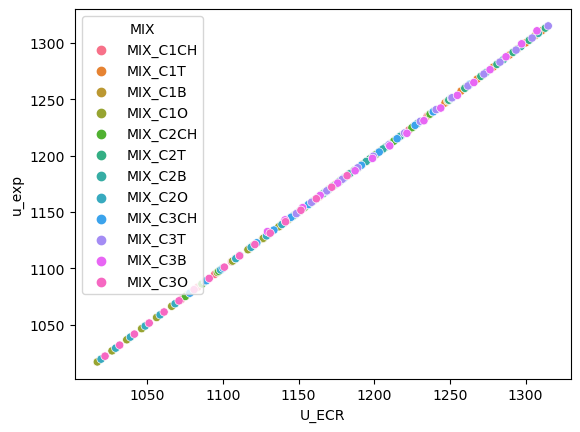

In [15]:
import seaborn as sns
sns.scatterplot(New_df,x="U_ECR",y="u_exp",hue="MIX")


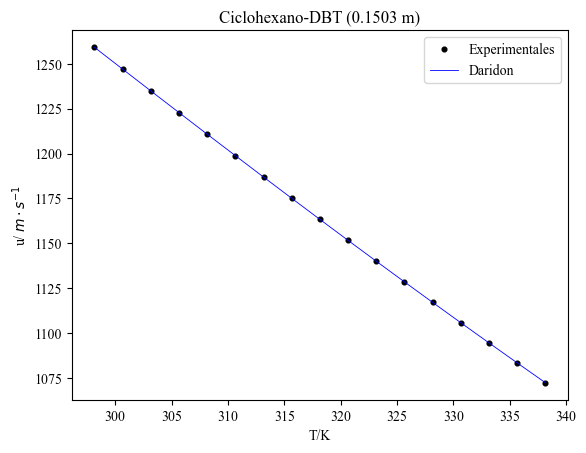

In [16]:
TITULOS=["Ciclohexano-DBT (0.1503 m)","Tolueno-DBT (0.1373 m)","Benceno-DBT (0.1620 m)","n-Octano-DBT (0.1108 m)",
             "Ciclohexano-DBT (0.2277 m)","Tolueno-DBT (0.2080 m)","Benceno-DBT (0.2452 m)","n-Octano-DBT (0.1678 m)",
             "Ciclohexano-DBT (0.3044 m)","Tolueno-DBT (0.2785 m)" ,"Benceno-DBT (0.3284 m)","n-Octano-DBT (0.2247 m)"]  
Guardar=["Speed_S_CH_DBT_C1.svg","Speed_S_T_DBT_C1.svg","Speed_S_B_DBT_C1.svg","Speed_S_O_DBT_C1.svg",
         "Speed_S_CH_DBT_C2.svg","Speed_S_T_DBT_C2.svg","Speed_S_B_DBT_C2.svg","Speed_S_O_DBT_C2.svg",
         "Speed_S_CH_DBT_C3.svg","Speed_S_T_DBT_C3.svg","Speed_S_B_DBT_C3.svg","Speed_S_O_DBT_C3.svg",]

GCAS(DF_MIXTURES["T[K]"].to_numpy(dtype=float),New_df["u_exp"].values[0:17],New_df["U_ECR"].values[0:17],TITULOS[0],Guardar[0])

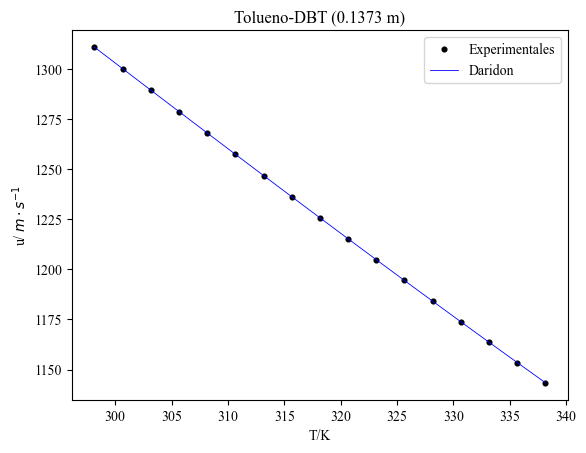

In [17]:
GCAS(DF_MIXTURES["T[K]"].to_numpy(dtype=float),New_df["u_exp"].values[17:34],New_df["U_ECR"].values[17:34],TITULOS[1],Guardar[1])    

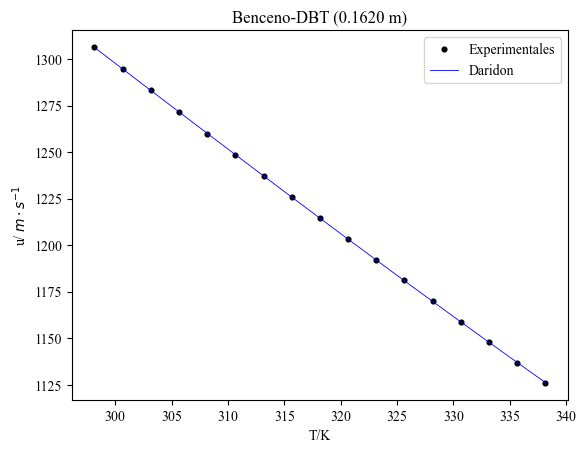

In [18]:
GCAS(DF_MIXTURES["T[K]"].to_numpy(dtype=float),New_df["u_exp"].values[34:51],New_df["U_ECR"].values[34:51],TITULOS[2],Guardar[2])    

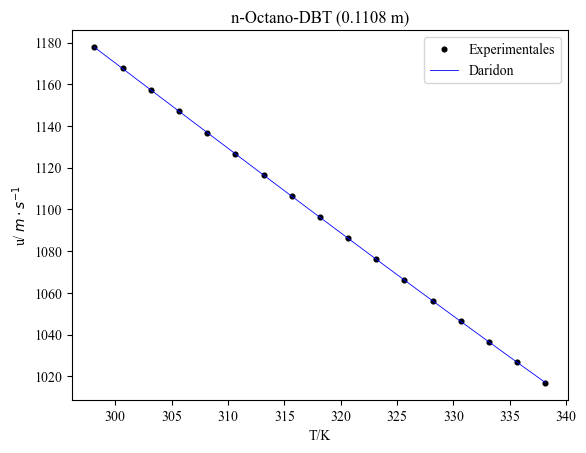

In [19]:
GCAS(DF_MIXTURES["T[K]"].to_numpy(dtype=float),New_df["u_exp"].values[51:68],New_df["U_ECR"].values[51:68],TITULOS[3],Guardar[3])    

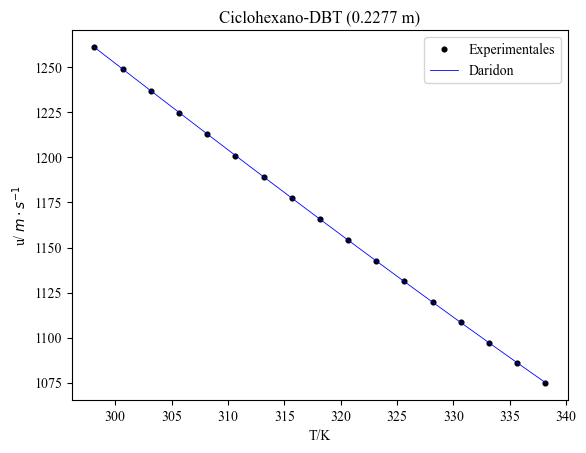

In [20]:
GCAS(DF_MIXTURES["T[K]"].to_numpy(dtype=float),New_df["u_exp"].values[68:85],New_df["U_ECR"].values[68:85],TITULOS[4],Guardar[4])    

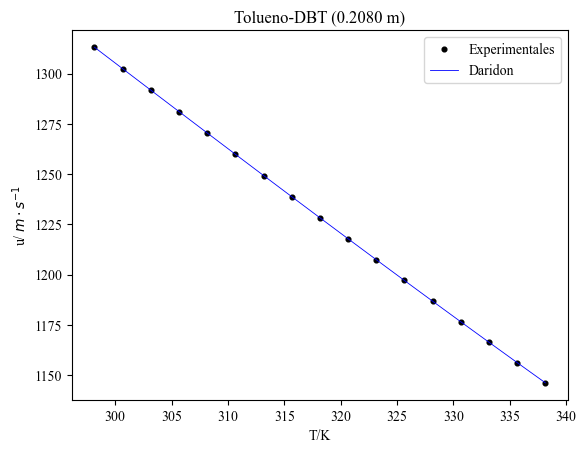

In [21]:
GCAS(DF_MIXTURES["T[K]"].to_numpy(dtype=float),New_df["u_exp"].values[85:102],New_df["U_ECR"].values[85:102],TITULOS[5],Guardar[5])    

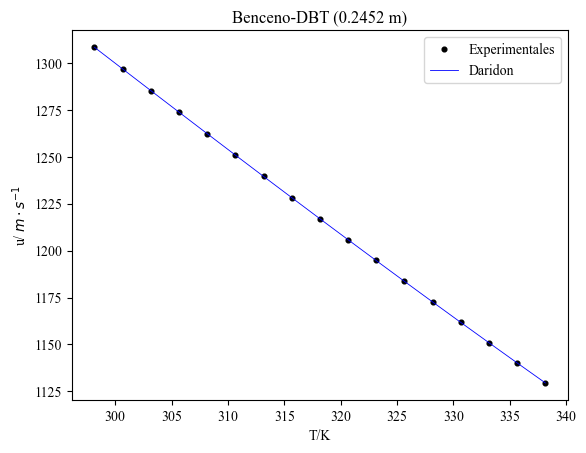

In [22]:
GCAS(DF_MIXTURES["T[K]"].to_numpy(dtype=float),New_df["u_exp"].values[102:119],New_df["U_ECR"].values[102:119],TITULOS[6],Guardar[6])    

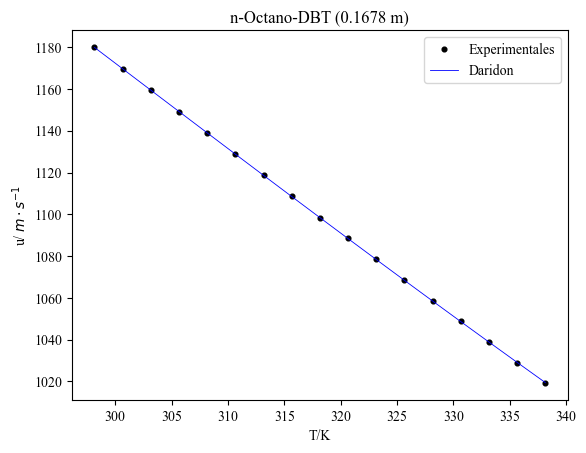

In [23]:
GCAS(DF_MIXTURES["T[K]"].to_numpy(dtype=float),New_df["u_exp"].values[119:136],New_df["U_ECR"].values[119:136],TITULOS[7],Guardar[7])    

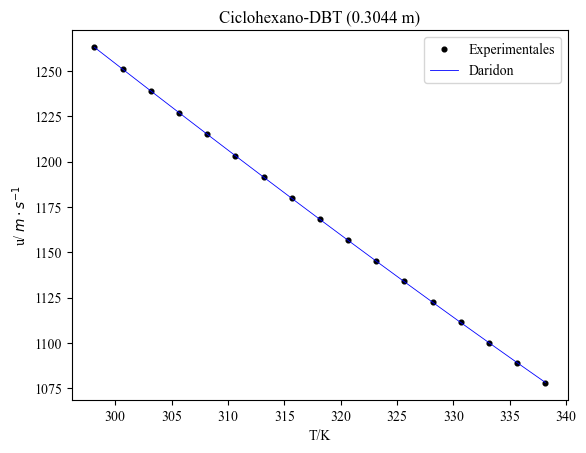

In [24]:
GCAS(DF_MIXTURES["T[K]"].to_numpy(dtype=float),New_df["u_exp"].values[136:153],New_df["U_ECR"].values[136:153],TITULOS[8],Guardar[8])    

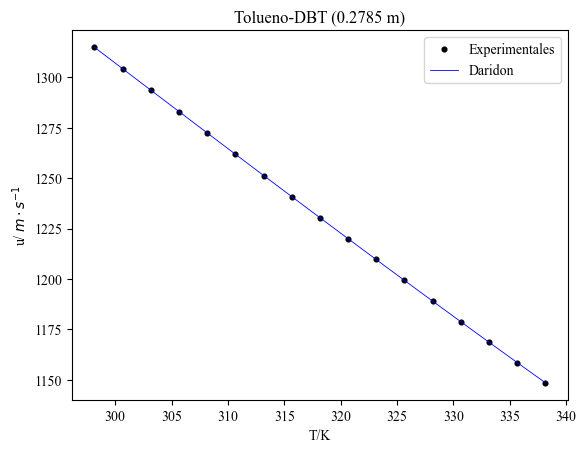

In [25]:
GCAS(DF_MIXTURES["T[K]"].to_numpy(dtype=float),New_df["u_exp"].values[153:170],New_df["U_ECR"].values[153:170],TITULOS[9],Guardar[9])    

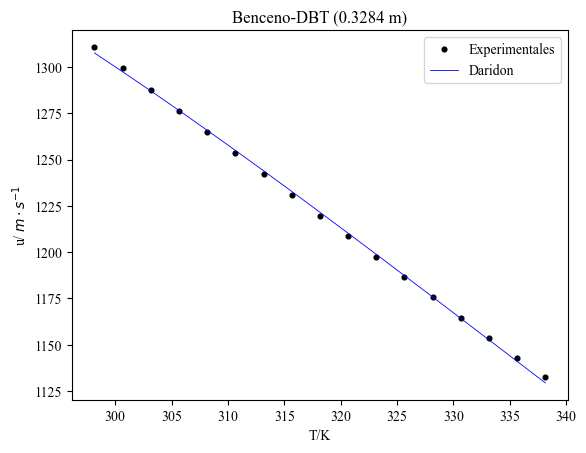

In [26]:
GCAS(DF_MIXTURES["T[K]"].to_numpy(dtype=float),New_df["u_exp"].values[170:187],New_df["U_ECR"].values[170:187],TITULOS[10],Guardar[10])    

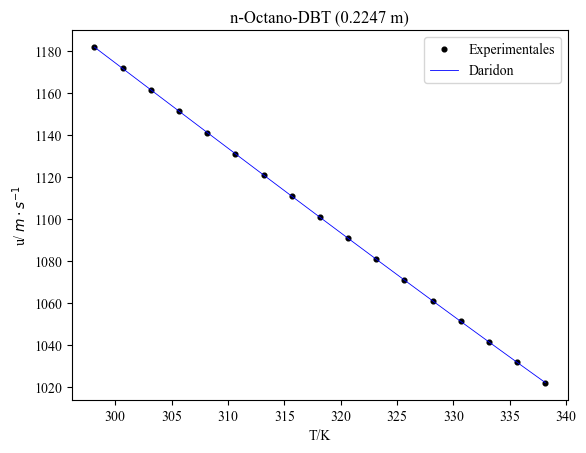

In [27]:
GCAS(DF_MIXTURES["T[K]"].to_numpy(dtype=float),New_df["u_exp"].values[187:204],New_df["U_ECR"].values[187:204],TITULOS[11],Guardar[11])    

In [28]:
#Dataframe que tiene los ssres
DF_SSRES=pd.DataFrame(OPT_GLOBAL(V0,DF_MIXTURES["T[K]"].to_numpy(dtype=float),DF_MIXTURES,COMPONENTS,XS)[1])
DF_SSRES.head()
#DF_SSRES.to_excel("SSRES models speed sound.xlsx")

,MIX,SSRES_ECR
0,MIX_C1CH,0.257196
1,MIX_C1T,0.079799
2,MIX_C1B,0.392309
3,MIX_C1O,0.132049
4,MIX_C2CH,0.230116


In [29]:
DF_PARS=pd.DataFrame(OPT_GLOBAL(V0,DF_MIXTURES["T[K]"].to_numpy(dtype=float),DF_MIXTURES,COMPONENTS,XS)[2])
DF_PARS.head()

,MIX,PAR_ECR
0,MIX_C1CH,"[9.57909951383674e-09, -4.7219953963976613e-07..."
1,MIX_C1T,"[4.27276077e-07, -2.27891083e-07, -1.39691326e..."
2,MIX_C1B,"[4.6342571125243e-07, -2.946916823215561e-07, ..."
3,MIX_C1O,"[5.037337636720839e-07, -4.046943472597193e-07..."
4,MIX_C2CH,"[7.105267939808647e-07, -1.4106760145123197e-0..."


In [30]:
New_df2=pd.DataFrame()
New_df2["MIX"]=DF_PARS.explode("PAR_ECR")["MIX"]
New_df2["PAR_ECR"]=DF_PARS.explode("PAR_ECR")["PAR_ECR"]
New_df2.head()

,MIX,PAR_ECR
0,MIX_C1CH,0.0
0,MIX_C1CH,-0.0
0,MIX_C1CH,-0.000002
0,MIX_C1CH,0.000006
0,MIX_C1CH,0.000001


In [31]:
#Generar un excel de resumen de todos los modelos de viscosidad
LIST_SHEET=["Models_speed_sound_results","PAR_ECR_for_model","SSRES_models"]
mm_s=[New_df,New_df2,DF_SSRES]
writer_m=pd.ExcelWriter("Tablas_de_Modelos_Speed_sound_con_parS.xlsx",engine="xlsxwriter")
for i, df_ms in enumerate(mm_s):
    df_ms.to_excel(writer_m,sheet_name=LIST_SHEET[i],index=False)
writer_m.save()